# 합성곱 신경망 감성 분류기

이 노트북에서는 *합성곱 신경망* 을 만들어 감성에 따라 IMDB 영화 리뷰를 분류합니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-3.convolutional_sentiment_classifier.ipynb)

#### 라이브러리를 적재합니다.

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 하이퍼파라미터를 설정합니다.

In [2]:
# 출력 디렉토리
output_dir = 'model_output/conv'

# 훈련
epochs = 4
batch_size = 128

# 벡터 공간 임베딩
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# 합성곱 층 구조
n_conv = 256 # 필터 또는 커널
k_conv = 3 # 커널 크기

# 밀집 층 구조
n_dense = 256
dropout = 0.2

#### 데이터를 적재합니다.

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # n_words_to_skip 삭제

17465344/17464789 [==============================] - 1s 0us/step


#### 데이터 전처리

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 신경망 만들기

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

#### 모델 설정

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 훈련!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 5s 25ms/step - loss: 0.4925 - accuracy: 0.7353 - val_loss: 0.3125 - val_accuracy: 0.8633
Epoch 2/4
196/196 [==============================] - 4s 23ms/step - loss: 0.2513 - accuracy: 0.8967 - val_loss: 0.2539 - val_accuracy: 0.8940
Epoch 3/4
196/196 [==============================] - 4s 23ms/step - loss: 0.1674 - accuracy: 0.9361 - val_loss: 0.2589 - val_accuracy: 0.8953
Epoch 4/4
196/196 [==============================] - 4s 22ms/step - loss: 0.1101 - accuracy: 0.9627 - val_loss: 0.2856 - val_accuracy: 0.8915


#### 평가

In [10]:
model.load_weights(output_dir+"/weights.03.hdf5") 

In [11]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


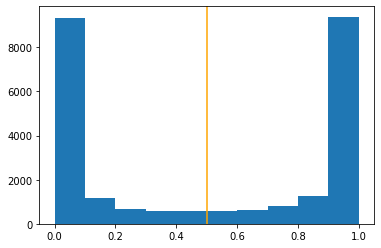

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.11'